# Symbol - Neural network graphs and auto-differentiation

In a [previous tutorial](http://mxnet.io/tutorials/basic/ndarray.html), we introduced `NDArray`,
the basic data structure for manipulating data in MXNet.
And just using NDArray by itself, we can execute a wide range of mathematical operations.
In fact, we could define and update a full neural network just by using `NDArray`.
`NDArray` allows you to write programs for scientific computation
in an imperative fashion, making full use of the native control of any front-end language.
So you might wonder, why don't we just use `NDArray` for all computation?

MXNet provides the Symbol API, an interface for symbolic programming.
With symbolic programming, rather than executing operations step by step,
we first define a *computation graph*.
This graph contains placeholders for inputs and designated outputs.
We can then compile the graph, yielding a function
that can be bound to `NDArray`s and run.
MXNet's Symbol API is similar to the network configurations
used by [Caffe](http://caffe.berkeleyvision.org/)
and the symbolic programming in [Theano](http://deeplearning.net/software/theano/).

Another advantage conferred by symbolic approach is that
we can optimize our functions before using them.
For example, when we execute mathematical computations in imperative fashion,
we don't know at the time that we run each operation,
which values will be needed later on.
But with symbolic programming, we declare the required outputs in advance.
This means that we can recycle memory allocated in intermediate steps,
as by performing operations in place. Symbolic API also uses less memory for the
same network. Refer to [How To](http://mxnet.io/how_to/index.html) and
[Architecture](http://mxnet.io/architecture/index.html) section to know more.

In our design notes, we present [a more thorough discussion on the comparative strengths
of imperative and symbolic programing](http://mxnet.io/architecture/program_model.html).
But in this document, we'll focus on teaching you how to use MXNet's Symbol API.
In MXNet, we can compose Symbols from other Symbols, using operators,
such as simple matrix operations (e.g. "+"),
or whole neural network layers (e.g. convolution layer).
Operator can take multiple input variables,
can produce multiple output symbols
and can maintain internal state symbols.

For a visual explanation of these concepts, see
[Symbolic Configuration and Execution in Pictures](http://mxnet.io/api/python/symbol_in_pictures.html).

To make things concrete, let's take a hands-on look at the Symbol API.
There are a few different ways to compose a `Symbol`.

## Prerequisites

To complete this tutorial, we need:

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/get_started/install.html)
- [Jupyter](http://jupyter.org/)
    ```
    pip install jupyter
    ```
- GPUs - A section of this tutorial uses GPUs. If you don't have GPUs on your machine, simply
set the variable gpu_device to mx.cpu().

## Basic Symbol Composition

### Basic Operators

The following example builds a simple expression: `a + b`.
First, we create two placeholders with  `mx.sym.Variable`,
giving them the names `a` and `b`.
We then construct the desired symbol by using the operator `+`.
We don't need to name our variables while creating them,
MXNet will automatically generate a unique name for each.
In the example below, `c` is assigned a unique name automatically.

In [20]:
import mxnet as mx
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
(a, b, c)

(<Symbol a>, <Symbol b>, <Symbol _plus4>)

In [19]:
??mx.sym.Variable

Most operators supported by `NDArray` are also supported by `Symbol`, for example:

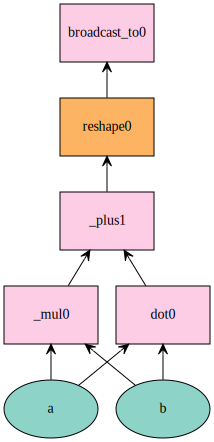

In [2]:
# elemental wise multiplication
d = a * b
# matrix multiplication
e = mx.sym.dot(a, b)
# reshape
f = mx.sym.reshape(d+e, shape=(1,4))
# broadcast
g = mx.sym.broadcast_to(f, shape=(2,4))
# plot
mx.viz.plot_network(symbol=g)

The computations declared in the above examples can be bound to the input data
for evaluation by using `bind` method. We discuss this further in the
[symbol manipulation](#Symbol Manipulation) section.

### Basic Neural Networks

Besides the basic operators, `Symbol` also supports a rich set of neural network layers.
The following example constructs a two layer fully connected neural network
and then visualizes the structure of that network given the input data shape.

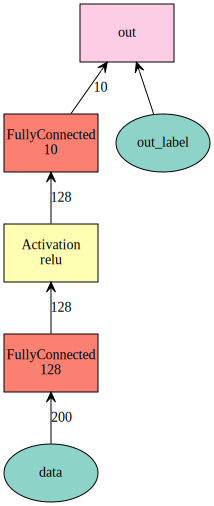

In [3]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net, shape={'data':(100,200)})

Each symbol takes a (unique) string name. NDArray and Symbol both represent
a single tensor. *Operators* represent the computation between tensors.
Operators take symbol (or NDArray) as inputs and might also additionally accept
other hyperparameters such as the number of hidden neurons (*num_hidden*) or the
activation type (*act_type*) and produce the output.

We can view a symbol simply as a function taking several arguments.
And we can retrieve those arguments with the following method call:

In [4]:
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

These arguments are the parameters and inputs needed by each symbol:

- *data*: Input data needed by the variable *data*.
- *fc1_weight* and *fc1_bias*: The weight and bias for the first fully connected layer *fc1*.
- *fc2_weight* and *fc2_bias*: The weight and bias for the second fully connected layer *fc2*.
- *out_label*: The label needed by the loss.

We can also specify the names explicitly:

In [5]:
net = mx.symbol.Variable('data')
w = mx.symbol.Variable('myweight')
net = mx.symbol.FullyConnected(data=net, weight=w, name='fc1', num_hidden=128)
net.list_arguments()

['data', 'myweight', 'fc1_bias']

In the above example, `FullyConnected` layer has 3 inputs: data, weight, bias.
When any input is not specified, a variable will be automatically generated for it.

## More Complicated Composition

MXNet provides well-optimized symbols for layers commonly used in deep learning
(see [src/operator](https://github.com/dmlc/mxnet/tree/master/src/operator)).
We can also define new operators in Python. The following example first
performs an element-wise add between two symbols, then feeds them to the fully
connected operator:

In [6]:
lhs = mx.symbol.Variable('data1')
rhs = mx.symbol.Variable('data2')
net = mx.symbol.FullyConnected(data=lhs + rhs, name='fc1', num_hidden=128)
net.list_arguments()

['data1', 'data2', 'fc1_weight', 'fc1_bias']

We can also construct a symbol in a more flexible way than the single forward
composition depicted in the preceding example:

In [7]:
data = mx.symbol.Variable('data')
net1 = mx.symbol.FullyConnected(data=data, name='fc1', num_hidden=10)
net1.list_arguments()
net2 = mx.symbol.Variable('data2')
net2 = mx.symbol.FullyConnected(data=net2, name='fc2', num_hidden=10)
composed = net2(data2=net1, name='composed')
composed.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias']

In this example, *net2* is used as a function to apply to an existing symbol *net1*,
and the resulting *composed* symbol will have all the attributes of *net1* and *net2*.

Once you start building some bigger networks, you might want to name some
symbols with a common prefix to outline the structure of your network.
You can use the
[Prefix](https://github.com/dmlc/mxnet/blob/master/python/mxnet/name.py)
NameManager as follows:

In [8]:
data = mx.sym.Variable("data")
net = data
n_layer = 2
for i in range(n_layer):
    with mx.name.Prefix("layer%d_" % (i + 1)):
        net = mx.sym.FullyConnected(data=net, name="fc", num_hidden=100)
net.list_arguments()

['data',
 'layer1_fc_weight',
 'layer1_fc_bias',
 'layer2_fc_weight',
 'layer2_fc_bias']

### Modularized Construction for Deep Networks

Constructing a *deep* network layer by layer, (like the Google Inception network),
can be tedious owing to the large number of layers.
So, for such networks, we often modularize the construction.

For example, in Google Inception network,
we can first define a factory function which chains the convolution,
batch normalization and rectified linear unit (ReLU) activation layers together.

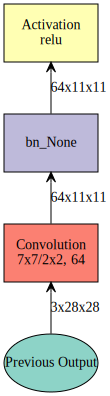

In [9]:
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0),name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel,
                  stride=stride, pad=pad, name='conv_%s%s' %(name, suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn_%s%s' %(name, suffix))
    act = mx.sym.Activation(data=bn, act_type='relu', name='relu_%s%s'
                  %(name, suffix))
    return act
prev = mx.sym.Variable(name="Previous Output")
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7,7), stride=(2, 2))
shape = {"Previous Output" : (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape)

Then we can define a function that constructs an inception module based on
factory function `ConvFactory`.

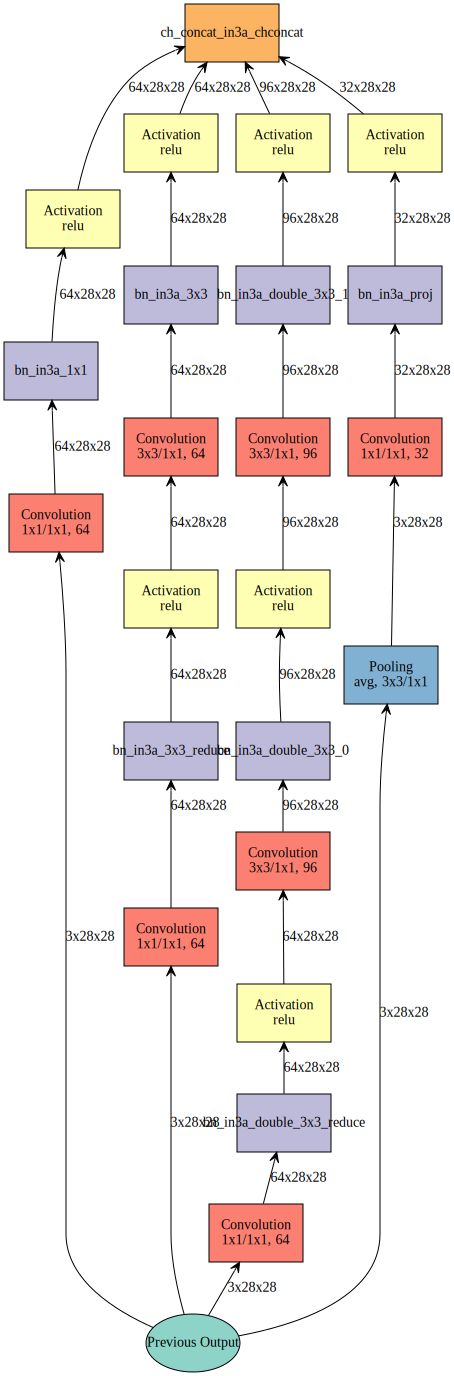

In [10]:
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3,
                      pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1), name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_1' % name))
    # pool + proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.sym.Concat(*[c1x1, c3x3, cd3x3, cproj], name='ch_concat_%s_chconcat' % name)
    return concat
prev = mx.sym.Variable(name="Previous Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
mx.viz.plot_network(symbol=in3a, shape=shape)

Finally, we can obtain the whole network by chaining multiple inception
modules. See a complete example
[here](https://github.com/dmlc/mxnet/blob/master/example/image-classification/symbols/inception-bn.py).

### Group Multiple Symbols

To construct neural networks with multiple loss layers, we can use
`mxnet.sym.Group` to group multiple symbols together. The following example
groups two outputs:

In [11]:
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
group.list_outputs()

['softmax_output', 'regression_output']

## Relations to NDArray

As you can see now, both `Symbol` and `NDArray` provide multi-dimensional array
operations, such as `c = a + b` in MXNet. We briefly clarify the differences here.

The `NDArray` provides an imperative programming alike interface, in which the
computations are evaluated sentence by sentence. While `Symbol` is closer to
declarative programming, in which we first declare the computation and then
evaluate with data. Examples in this category include regular expressions and
SQL.

The pros for `NDArray`:

- Straightforward.
- Easy to work with native language features (for loop, if-else condition, ..)
  and libraries (numpy, ..).
- Easy step-by-step code debugging.

The pros for `Symbol`:

- Provides almost all functionalities of NDArray, such as `+`, `*`, `sin`,
  `reshape` etc.
- Easy to save, load and visualize.
- Easy for the backend to optimize the computation and memory usage.

## Symbol Manipulation

One important difference of `Symbol` compared to `NDArray` is that we first
declare the computation and then bind the computation with data to run.

In this section, we introduce the functions to manipulate a symbol directly. But
note that, most of them are wrapped by the `module` package.

### Shape and Type Inference

For each symbol, we can query its arguments, auxiliary states and outputs.
We can also infer the output shape and type of the symbol given the known input
shape or type of some arguments, which facilitates memory allocation.

In [12]:
arg_name = c.list_arguments()  # get the names of the inputs
out_name = c.list_outputs()    # get the names of the outputs
# infers output shape given the shape of input arguments
arg_shape, out_shape, _ = c.infer_shape(a=(2,3), b=(2,3))
# infers output type given the type of input arguments
arg_type, out_type, _ = c.infer_type(a='float32', b='float32')
{'input' : dict(zip(arg_name, arg_shape)),
 'output' : dict(zip(out_name, out_shape))}
{'input' : dict(zip(arg_name, arg_type)),
 'output' : dict(zip(out_name, out_type))}

{'input': {'a': numpy.float32, 'b': numpy.float32},
 'output': {'_plus0_output': numpy.float32}}

### Bind with Data and Evaluate

The symbol `c` constructed above declares what computation should be run. To
evaluate it, we first need to feed the arguments, namely free variables, with data.

We can do it by using the `bind` method, which accepts device context and
a `dict` mapping free variable names to `NDArray`s as arguments and returns an
executor. The executor provides `forward` method for evaluation and an attribute
`outputs` to get all the results.

In [13]:
ex = c.bind(ctx=mx.cpu(), args={'a' : mx.nd.ones([2,3]),
                                'b' : mx.nd.ones([2,3])})
ex.forward()
print('number of outputs = %d\nthe first output = \n%s' % (
           len(ex.outputs), ex.outputs[0].asnumpy()))

number of outputs = 1
the first output = 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


We can evaluate the same symbol on GPU with different data.

**Note** In order to execute the following section on a cpu set gpu_device to mx.cpu().

In [14]:
gpu_device=mx.gpu() # Change this to mx.cpu() in absence of GPUs.

ex_gpu = c.bind(ctx=gpu_device, args={'a' : mx.nd.ones([3,4], gpu_device)*2,
                                      'b' : mx.nd.ones([3,4], gpu_device)*3})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()

array([[ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.]], dtype=float32)

We can also use `eval` method to evaluate the symbol. It combines calls to `bind`
and `forward` methods.

In [15]:
ex = c.eval(ctx = mx.cpu(), a = mx.nd.ones([2,3]), b = mx.nd.ones([2,3]))
print('number of outputs = %d\nthe first output = \n%s' % (
            len(ex), ex[0].asnumpy()))

number of outputs = 1
the first output = 
[[ 2.  2.  2.]
 [ 2.  2.  2.]]


For neural nets, a more commonly used pattern is ```simple_bind```, which
creates all of the argument arrays for you. Then you can call ```forward```,
and ```backward``` (if the gradient is needed) to get the gradient.

### Load and Save

Logically symbols correspond to ndarrays. They both represent a tensor. They both
are inputs/outputs of operators. We can either serialize a `Symbol` object by
using `pickle`, or by using `save` and `load` methods directly as we discussed in
[NDArray tutorial](http://mxnet.io/tutorials/basic/ndarray.html#serialize-from-to-distributed-filesystems).

When serializing `NDArray`, we serialize the tensor data in it and directly dump to
disk in binary format.
But symbol uses a concept of graph. Graphs are composed by chaining operators. They are
implicitly represented by output symbols. So, when serializing a `Symbol`, we
serialize the graph of which the symbol is an output. While serialization, Symbol
uses more readable `json` format for serialization. To convert symbol to `json`
string, use `tojson` method.

In [16]:
print(c.tojson())
c.save('symbol-c.json')
c2 = mx.sym.load('symbol-c.json')
c.tojson() == c2.tojson()

{
  "nodes": [
    {
      "op": "null", 
      "name": "a", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "b", 
      "inputs": []
    }, 
    {
      "op": "elemwise_add", 
      "name": "_plus0", 
      "inputs": [[0, 0, 0], [1, 0, 0]]
    }
  ], 
  "arg_nodes": [0, 1], 
  "node_row_ptr": [0, 1, 2, 3], 
  "heads": [[2, 0, 0]], 
  "attrs": {"mxnet_version": ["int", 10001]}
}


True

## Customized Symbol

Most operators such as `mx.sym.Convolution` and `mx.sym.Reshape` are implemented
in C++ for better performance. MXNet also allows users to write new operators
using any front-end language such as Python. It often makes the developing and
debugging much easier. To implement an operator in Python, refer to
[How to create new operators](http://mxnet.io/how_to/new_op.html).

## Advanced Usages

### Type Cast

By default, MXNet uses 32-bit floats.
But for better accuracy-performance,
we can also use a lower precision data type.
For example, The Nvidia Tesla Pascal GPUs
(e.g. P100) have improved 16-bit float performance,
while GTX Pascal GPUs (e.g. GTX 1080) are fast on 8-bit integers.

To convert the data type as per the requirements,
we can use `mx.sym.cast` operator as follows:

In [17]:
a = mx.sym.Variable('data')
b = mx.sym.cast(data=a, dtype='float16')
arg, out, _ = b.infer_type(data='float32')
print({'input':arg, 'output':out})

c = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
print({'input':arg, 'output':out})

{'input': [<class 'numpy.float32'>], 'output': [<class 'numpy.float16'>]}
{'input': [<class 'numpy.int32'>], 'output': [<class 'numpy.uint8'>]}


### Variable Sharing

To share the contents between several symbols,
we can bind these symbols with the same array as follows:

In [18]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
b = a + a * a

data = mx.nd.ones((2,3))*2
ex = b.bind(ctx=mx.cpu(), args={'a':data, 'b':data})
ex.forward()
ex.outputs[0].asnumpy()

array([[ 6.,  6.,  6.],
       [ 6.,  6.,  6.]], dtype=float32)


<!-- INSERT SOURCE DOWNLOAD BUTTONS -->

